In [1]:
%cd ../..


c:\Users\yanic\dev\ethz\cil\CIL2023


In [2]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision
from torchvision.io import ImageReadMode

from joblib import Parallel, delayed

import cv2

# Reconstruction
Reconstructs a mask from angle, width & distance data

#### Config

In [3]:
# folders should contain mean/ and std/ subfolders
angle_folder = "out/madw_angle/run_data5k"
distance_folder = "out/madw_dist/run_data5k_last"
width_folder = "out/madw_width/run_data5k_last"
mask_prior_folder = None # "out/madw_prior/run_test" # set to None if you don't want to include prior masks
out_folder = "out/madw/data5k"

RESIZE_FACTOR = 0.25
BINARIZE_OUTPUT = True
BINARIZATION_PERCENTILE = 75 # in %
MASK_PRIOR_THRESHOLD = 0.5
OVERWRITE = False # whether to overwrite existing priors

#### This must be the same as in ADW-Transform!

In [4]:
PADDING = 25
SMOOTH_ANGLE = 2.0 # None to disable
SMOOTH_WIDTH = 1.0 # None to disable
SMOOTH_MASK_ITERATIONS = 3

# the image size that the model will be working on (matters for distance prediction!)
TARGET_SIZE = (224,224) 
# leave at (400,400) if doing cropping
# use (224,224) if rescaling

NORM_ANGLE_MIN, NORM_ANGLE_DELTA = -3.15, 6.3
NORM_DISTANCE_MIN, NORM_DISTANCE_DELTA = 0, np.sqrt(2*(TARGET_SIZE[0] + 2*PADDING)**2) + 1
NORM_WIDTH_MIN, NORM_WIDTH_DELTA = 0, TARGET_SIZE[0] / 4 # this might cause some overflows if chosen too small

In [5]:
def nearest_neighbor_interpolation_2D(arr, target_size):
    current_size = arr.shape
    row_ratio, col_ratio = np.array(target_size)/np.array(current_size)

    row_idx = (np.ceil(range(1, 1 + int(current_size[0]*row_ratio))/row_ratio) - 1).astype(int)
    col_idx = (np.ceil(range(1, 1 + int(current_size[1]*col_ratio))/col_ratio) - 1).astype(int)

    return arr[:,row_idx][col_idx,:]

In [6]:
def cart2pol(x, y, m_alpha):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if m_alpha - phi > (2*np.pi + phi) - m_alpha:
        phi = 2*np.pi + phi
    return(rho, phi)

In [7]:
def norm_to_true(angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std, 
                 angle_min, angle_delta, distance_min, distance_delta, width_min, width_delta):
    angle_mean = angle_mean * angle_delta + angle_min
    angle_std = angle_std * angle_delta

    distance_mean = distance_mean * distance_delta + distance_min
    distance_std = distance_std * distance_delta

    width_mean = width_mean * width_delta + width_min
    width_std = width_std * width_delta    

    return angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std

In [8]:
def load_sample(name):
    angle_mean = (torchvision.io.read_image(os.path.join(angle_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    angle_std = (torchvision.io.read_image(os.path.join(angle_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    distance_mean = (torchvision.io.read_image(os.path.join(distance_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    distance_std = (torchvision.io.read_image(os.path.join(distance_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    width_mean = (torchvision.io.read_image(os.path.join(width_folder, 'mean', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
    width_std = (torchvision.io.read_image(os.path.join(width_folder, 'std', name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()

    return norm_to_true(angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std, 
                        NORM_ANGLE_MIN, NORM_ANGLE_DELTA, NORM_DISTANCE_MIN, NORM_DISTANCE_DELTA, NORM_WIDTH_MIN, NORM_WIDTH_DELTA)

In [9]:
def visualize_sample(angle_mean, angle_std, distance_mean, distance_std, width_mean, width_std):
    def print_info(name, data_mean, data_std):
        print(f"{name} Mean: min {data_mean.min()}, max {data_mean.max()}, mean {data_mean.mean()}")
        print(f"{name} Std: min {data_std.min()}, max {data_std.max()}, mean {data_std.mean()}")

    fig,axs = plt.subplots(2,3)
    for ax in axs.flat:
        ax.axis('off')

    axs[0,0].set_title("angle")
    axs[0,0].imshow(angle_mean)
    axs[1,0].imshow(angle_std)

    axs[0,1].set_title("distance")
    axs[0,1].imshow(distance_mean)
    axs[1,1].imshow(distance_std)

    axs[0,2].set_title("width")
    axs[0,2].imshow(width_mean)
    axs[1,2].imshow(width_std)

    print_info("Angle", angle_mean, angle_std)
    print_info("Distance", distance_mean, distance_std)
    print_info("Width", width_mean, width_std)

    plt.tight_layout()
    plt.show()

In [10]:
def clamp_outliers(data, perc):
    # perc from 0 - 100
    thresh_low = np.percentile(data, perc)
    thresh_high = np.percentile(data, 100 - perc)
    data[data < thresh_low] = thresh_low
    data[data > thresh_high] = thresh_high
    return data

In [11]:
def aggregate_votes(angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std, resize_factor = 0.25):
    original_size = angle_mean.shape[-1]
    # subsample
    size = round(resize_factor * original_size)

    res_total_weight = np.zeros((size,size))
    res_width_mean = np.zeros((size,size))
    res_width_std = np.zeros((size,size))

    angle_mean = nearest_neighbor_interpolation_2D(angle_mean, (size,size)) # invariant to scaling
    angle_std = nearest_neighbor_interpolation_2D(angle_std, (size,size))
    dist_mean = nearest_neighbor_interpolation_2D(dist_mean, (size,size)) * resize_factor # k * X ~ N(k * m, (k*s)^2)
    dist_std = nearest_neighbor_interpolation_2D(dist_std, (size,size)) * resize_factor
    width_mean = nearest_neighbor_interpolation_2D(width_mean, (size,size)) # keep original scale
    width_std = nearest_neighbor_interpolation_2D(width_std, (size,size))

    indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
    dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

    indices_2d = np.stack([indices_ext, indices_ext.T], axis=-1)
    angles = np.arctan2(indices_2d[:,:,0], indices_2d[:,:,1])

    res_total_weight = np.zeros((size,size))
    res_width_mean = np.zeros((size,size))
    res_width_var = np.ones((size,size))

    joint_norm_std = 1 / (2 * np.pi * angle_std * dist_std)
    for y in range(size):
        for x in range(size):
            local_angle_mean = angle_mean[y,x]
            local_angle_std = angle_std[y,x]
            local_dist_mean = dist_mean[y,x]
            local_dist_std = dist_std[y,x]
            local_width_mean = width_mean[y,x]
            local_width_var = width_std[y,x] * width_std[y,x]
            
            local_dists = dists[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
            local_angles = angles[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
            closest_local_angles = local_angles + np.sign(local_angle_mean - local_angles) * (np.abs(local_angle_mean - local_angles) > np.pi) * 2 * np.pi

            prop_that_road = joint_norm_std[y,x] * np.exp(-0.5 * (((closest_local_angles - local_angles) / local_angle_std)**2 + ((local_dists - local_dist_mean) / local_dist_std)**2))

            res_total_weight += prop_that_road
            res_width_mean += prop_that_road * local_width_mean
            res_width_var += prop_that_road * (local_width_var + local_width_mean**2)
    res_width_mean /= res_total_weight
    res_width_var /= res_total_weight
    res_width_var -= res_width_mean**2
    res_width_std = np.sqrt(res_width_var)

    vote_width_mean = res_width_mean
    vote_width_std = res_width_std

    return vote_width_mean, vote_width_std

In [12]:
def construct_mask(vote_width_mean, vote_width_std, resize_factor = 0.25, mask_prior = None, prior_threshold = 0.5):
    size = vote_width_mean.shape[-1]

    # since we don't upscale
    vote_width_mean *= resize_factor
    vote_width_std *= resize_factor 

    indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
    dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

    res_mask = np.zeros((size,size))

    for y in range(size):
        for x in range(size):
            if vote_width_mean[y,x] < 0.1: 
                continue
            if mask_prior is not None:
                if mask_prior[y,x] < prior_threshold:
                    continue
            
            norm = stats.norm(vote_width_mean[y,x], vote_width_std[y,x])
            local_dists = dists[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
            
            prop_that_road = 1.0 - norm.cdf(local_dists)

            res_mask = np.maximum(res_mask, prop_that_road)

    return res_mask

# Generate Data

In [13]:
def process(i,img_name):
    output_path = os.path.join(out_folder, img_name)
    if not OVERWRITE and os.path.exists(output_path):
        return
    
    angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std = load_sample(img_name)
    original_size = angle_mean.shape[-1]

    dist_std /= 10.0 # seems to work better with lower dist

    vote_width_mean, vote_width_std = aggregate_votes(angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std, resize_factor=RESIZE_FACTOR)

    mask_prior = None
    if mask_prior_folder is not None:
        mask_prior = (torchvision.io.read_image(os.path.join(mask_prior_folder, img_name), mode=ImageReadMode.GRAY).squeeze()/255.0).numpy()
        
    res_mask = construct_mask(vote_width_mean, vote_width_std, resize_factor=RESIZE_FACTOR, mask_prior=mask_prior, prior_threshold=MASK_PRIOR_THRESHOLD)
    
    thresh_res_mask = res_mask
    if BINARIZE_OUTPUT:
        threshold = np.percentile(res_mask, BINARIZATION_PERCENTILE)
        thresh_res_mask = (res_mask > threshold) * 1.0

    output = nearest_neighbor_interpolation_2D(thresh_res_mask, (original_size,original_size))
    cv2.imwrite(output_path, output * 255)

In [14]:
os.makedirs(out_folder, exist_ok=True)
r = Parallel(n_jobs=8)(delayed(process)(i, img_name) for i,img_name in enumerate(os.listdir(os.path.join(angle_folder, 'mean'))))

# Manual

Angle Mean: min -2.1123528480529785, max 2.2111763954162598, mean -0.1256759613752365
Angle Std: min 0.06423529982566833, max 0.1976470649242401, mean 0.1321113109588623
Distance Mean: min 0.0, max 56.36979293823242, mean 25.123655319213867
Distance Std: min 3.96112060546875, max 4.722874641418457, mean 3.9627058506011963
Width Mean: min 1.5372549295425415, max 7.466667175292969, mean 3.5582573413848877
Width Std: min 5.709804058074951, max 7.466667175292969, mean 5.723213195800781


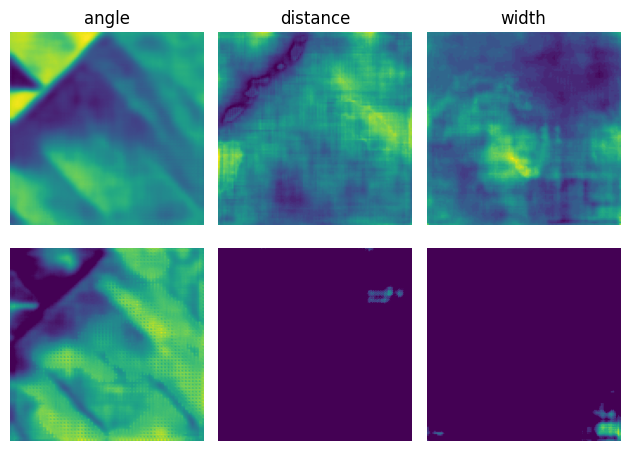

In [86]:
angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std = load_sample("satimage_144.png")
outlier_perc = 2.5
# angle_mean = clamp_outliers(angle_mean, outlier_perc)
# angle_std = clamp_outliers(angle_std, outlier_perc)
# dist_mean = clamp_outliers(dist_mean, outlier_perc)
# dist_std = clamp_outliers(dist_std, outlier_perc)
# width_mean = clamp_outliers(width_mean, outlier_perc)
# width_std = clamp_outliers(width_std, outlier_perc)

visualize_sample(angle_mean, angle_std, dist_mean, dist_std, width_mean, width_std)

## Voting Phase

In this phase, the votes for all widths at each point in space are aggregated

In [87]:
original_size = angle_mean.shape[-1]
print(original_size)

400


In [88]:
# subsample
resize_factor = 0.25 # by how much will the image resolution be reduced
size = round(resize_factor * original_size)

res_total_weight = np.zeros((size,size))
res_width_mean = np.zeros((size,size))
res_width_std = np.zeros((size,size))

angle_mean = nearest_neighbor_interpolation_2D(angle_mean, (size,size)) # invariant to scaling
angle_std = nearest_neighbor_interpolation_2D(angle_std, (size,size))
dist_mean = nearest_neighbor_interpolation_2D(dist_mean, (size,size)) * resize_factor # k * X ~ N(k * m, (k*s)^2)
dist_std = nearest_neighbor_interpolation_2D(dist_std, (size,size)) * resize_factor
width_mean = nearest_neighbor_interpolation_2D(width_mean, (size,size)) # keep original scale
width_std = nearest_neighbor_interpolation_2D(width_std, (size,size))

In [89]:
indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

indices_2d = np.stack([indices_ext, indices_ext.T], axis=-1)
angles = np.arctan2(indices_2d[:,:,0], indices_2d[:,:,1])

res_total_weight = np.zeros((size,size))
res_width_mean = np.zeros((size,size))
res_width_var = np.ones((size,size))

joint_norm_std = 1 / (2 * np.pi * angle_std * dist_std)
for y in tqdm(range(size)):
    for x in range(size):
        local_angle_mean = angle_mean[y,x]
        local_angle_std = angle_std[y,x]
        local_dist_mean = dist_mean[y,x]
        local_dist_std = dist_std[y,x]
        local_width_mean = width_mean[y,x]
        local_width_var = width_std[y,x] * width_std[y,x]
        
        local_dists = dists[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
        local_angles = angles[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
        closest_local_angles = local_angles + 2*np.pi*(local_angle_mean > np.pi + local_angles) 

        prop_that_road = joint_norm_std[y,x] * np.exp(-0.5 * (((closest_local_angles - local_angle_mean) / local_angle_std)**2 + ((local_dists - local_dist_mean) / local_dist_std)**2))

        res_total_weight += prop_that_road
        res_width_mean += prop_that_road * local_width_mean
        res_width_var += prop_that_road * (local_width_var + local_width_mean**2)
res_width_mean /= res_total_weight
res_width_var /= res_total_weight
res_width_var -= res_width_mean**2
res_width_std = np.sqrt(res_width_var)

# TODO: upsample using linear interpolation
vote_width_mean = res_width_mean
vote_width_std = res_width_std

# weight_threshold = np.percentile(res_total_weight.flatten(), 50)
# vote_width_mean[res_total_weight < weight_threshold] = 0
# vote_width_std[res_total_weight < weight_threshold] = vote_width_std.mean()

100%|██████████| 100/100 [00:04<00:00, 23.89it/s]


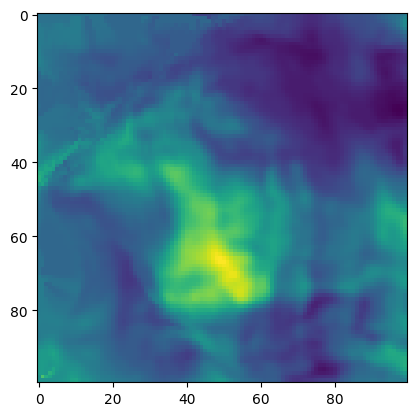

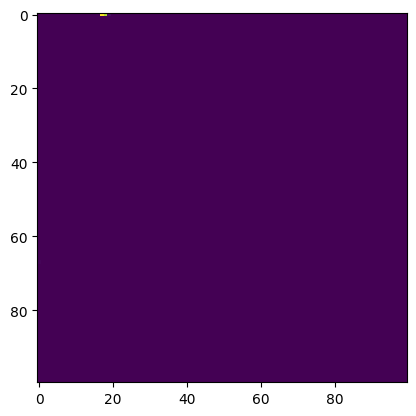

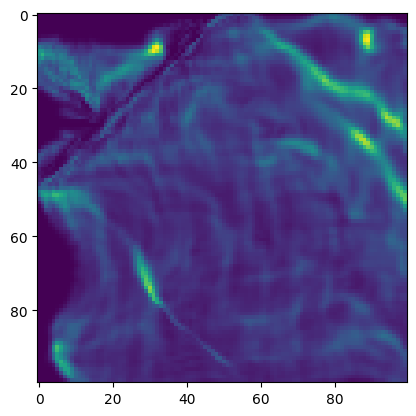

In [90]:
plt.imshow(res_width_mean)
plt.show()
plt.imshow(res_width_std)
plt.show()
plt.imshow(res_total_weight)
plt.show()

## Final Mask From Votes

In [91]:
size = size

# since we don't upscale
vote_width_mean *= resize_factor
vote_width_std *= resize_factor 

In [94]:
indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

res_mask = np.zeros((size,size))

for y in tqdm(range(size)):
    for x in range(size):
        if vote_width_mean[y,x] < 0.1: 
            continue
        
        norm = stats.norm(vote_width_mean[y,x], vote_width_std[y,x])
        local_dists = dists[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
        
        prop_that_road = 1.0 - norm.cdf(local_dists)

        res_mask = np.maximum(res_mask, prop_that_road)

100%|██████████| 100/100 [00:11<00:00,  8.99it/s]


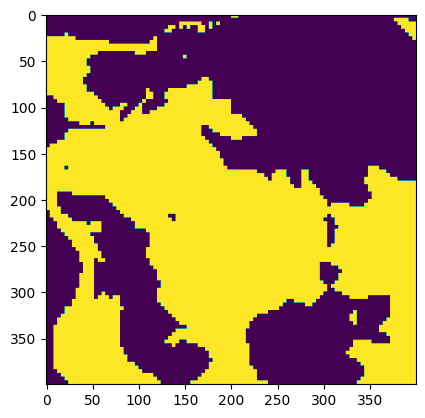

In [95]:
threshold = np.percentile(res_mask, 50)
thresh_res_mask = (res_mask > threshold) * 1.0
plt.imshow(nearest_neighbor_interpolation_2D(thresh_res_mask, (original_size,original_size)))
